In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyproj 
from scipy.interpolate import griddata
import pickle 
from multiprocess import Pool

# Import helper functions: 
import sys
sys.path.append('../scripts/')
from load_data import load_RCM, load_yearly_RCM


def grid_data(lat_ori, lon_ori, var_ori, ref_lat, ref_lon, method_name):
    
    '''
    Function used to interpolate/regrid melt data to the ASCAT grid (in this case). Important that the original 
    grid and new grid is in the same projection (in this case EPSG:3413)
    
    Input: lat_ori, lon_ori: coordinates of the original grid (2D arrays)
           var_ori: Data to be regridded on the original grid (2D arrays).
           ref_lon, ref_lat: 
           method: 
    
    Output: (melt)Data on the new grid. 
    '''
   
    grid_var = griddata((lon_ori.flatten(), lat_ori.flatten()), var_ori.flatten(), (ref_lon, ref_lat), method=method_name)

    return grid_var
    
# Function for multiprocessing the regridding of melt data: 
def multiprocess_griddig(doy):
    '''
    Function used for multiprocessing of the regridding of data. Depending on the resolution of the RCM, the method
    of the regridding might need to be changed. 
    
    Input: doy: day of the year 
    
    Outout: grid_var: Data on the new grid for the given day of the year. 
    '''
    
    data_var = melt_data[doy]
    grid_var = np.flipud(grid_data(polar_lat, polar_lon, data_var, tif_lat, tif_lon, 'nearest'))
    return grid_var   

# Choose RCM and year to regrid 

In [10]:
home_dir = '/Volumes/disk3s1/enveo/'
# Choose RCM and year:
RCM_name = 'CARRA'
year = 2014

# Now we import a year and one RCM for the full year: 
polar_lat, polar_lon, melt_data= load_yearly_RCM(home_dir, RCM_name, year)

# Open nc file with the desired grid; (Made using gdal_translate)
tif_grid = xr.open_dataset(home_dir + '/tif_grid.nc')

# Generate ASCAT grid: 
tif_x = tif_grid.x
tif_y = tif_grid.y
tif_lon, tif_lat = np.meshgrid(tif_x,tif_y)

OSError: no files to open

# Perform regridding and plot 

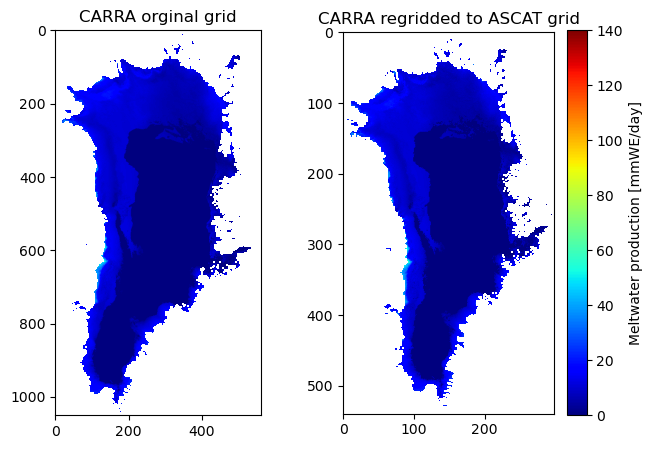

In [9]:
# Day of the year. 
doy = np.arange(0,np.size(melt_data,0))

# Regrid using multiprossing. Remember to check if the method is correct in the function definition.
pool = Pool(5)
pool_output = pool.map(multiprocess_griddig,doy)
pool.close()
pool.join 

# Reshape results:
data_regrid_shape = (np.size(melt_data,0), 540,299)
melt_regridded = np.reshape(pool_output, data_regrid_shape)

# Save as pickle:
with open(home_dir + f'/regriddedRCM/{RCM_name}_{year}_regridded_nearest.pkl','wb') as f:
    pickle.dump(melt_regridded, f)

# Plot orginal data and regridded data; 
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7.5,5))
ax2.imshow(melt_regridded[200],vmin = 0, vmax = 140,cmap ='jet')
im = ax1.imshow(np.flip(melt_data[200],0),vmin = 0, vmax = 140, cmap= 'jet' )
ax1.set_title(f'{RCM_name} orginal grid')
ax2.set_title(f'{RCM_name} regridded to ASCAT grid')
plt.colorbar(im, ax = ax2, label = 'Meltwater production [mmWE/day]')